In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
training_df = pd.read_csv('data/training_set.csv')
training_metadata_df = pd.read_csv('data/training_set_metadata.csv')

In [3]:
training_metadata_df.head(5)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [4]:
objs = np.unique(training_df.object_id)
passbands = [0, 1, 2, 3, 4, 5]
targets = np.unique(training_metadata_df.target)

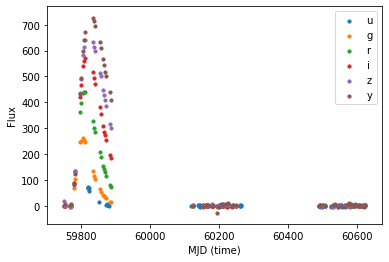

In [351]:
example = training_df[(training_df.object_id == objs[200])]
filters = ['u', 'g', 'r', 'i', 'z', 'y']
for i in np.arange(6):
    ex = example[(example.passband == passbands[i])]
    plt.scatter(ex.mjd, ex.flux, s=10, label=filters[i])
plt.xlabel('MJD (time)')
plt.ylabel('Flux')
plt.legend()
plt.savefig('example_observation.png', dpi=200, bbox_inches='tight')
plt.show()

# Normalize and interpolate time series

In [204]:
#training_df_new = pd.DataFrame({'object_id' : np.array([], dtype=int), 'flux' : []})
X = []
y = []
for obj in tqdm(objs):
    data = training_df[training_df.object_id == obj]
    #mean_mjd = np.mean(data.mjd)
    #std_mjd = np.std(data.mjd)
    min_mjd = np.min(data.mjd)
    max_mjd = np.max(data.mjd)
    #mean_flux = np.mean(data.flux)
    #std_flux = np.std(data.flux)
    min_flux = np.min(data.flux)
    max_flux = np.max(data.flux)
    flux_all = []
    for passband in passbands:
        #data = training_df[training_df.object_id == obj][training_df.passband == passband]
        data = training_df.loc[(training_df.object_id == obj) & (training_df.passband == passband)]
        norm_mjd = (data.mjd - min_mjd)/(max_mjd - min_mjd)
        norm_flux = (data.flux - min_flux)/(max_flux - min_flux)
        mjd_interp = np.linspace(np.min(norm_mjd), np.max(norm_mjd), 100)
        interp = interp1d(norm_mjd, norm_flux, kind='linear')
        flux_interp = interp(mjd_interp)
        flux_all += [flux_interp]
    X += [flux_all]
    y += [1.*(targets == int(training_metadata_df.loc[training_metadata_df.object_id == obj].target))]
    #df = pd.DataFrame(data={'object_id' : np.tile([obj], 6*len(mjd_interp)), 'flux' : flux_all})
    #training_df_new = training_df_new.append(df, ignore_index=True)

100%|██████████| 7848/7848 [07:08<00:00, 18.31it/s]


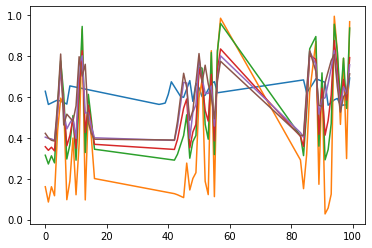

In [205]:
for passband in passbands:
    plt.plot(np.arange(len(X[0][passband])), X[0][passband])
plt.show()

# Deep Learning

In [292]:
import keras
import tensorflow as tf
import seaborn as sn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [206]:
N = []
for i in np.arange(len(targets)):
    N += [len(training_metadata_df.loc[training_metadata_df.target == targets[i]])]
w = N/np.sum(N)
print(targets)
print(w)

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]
[0.01924057 0.06307339 0.117737   0.15201325 0.02331804 0.00382263
 0.06167176 0.01299694 0.125      0.02650357 0.04714577 0.29472477
 0.03045362 0.02229867]


In [114]:
def LogLoss(y_true, y_pred):
    y_clip = tf.clip_by_value(y_pred, 1e-15, 1-1e-15)
    loss = -(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(y_clip), axis=0)/w))
    return loss

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, stratify=y)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
num_classes = len(targets)

In [142]:
activation = 'relu'
dropout_rate = 0.25
dense_model = Sequential()
dense_model.add(Reshape((6000,), input_shape=(6,1000)))

dense_model.add(Dense(512, activation=activation))
dense_model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

dense_model.add(Dense(256, activation=activation))
dense_model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

dense_model.add(Dense(128, activation=activation))
dense_model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

dense_model.add(Dense(64, activation=activation))
dense_model.add(BatchNormalization())
model.add(Dropout(dropout_rate/2))

dense_model.add(Dense(num_classes, activation='softmax'))
print(dense_model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 6000)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               3072512   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_47 (Batc (None, 256)               1024      
_________________________________________________________________
dense_67 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_48 (Batc (None, 128)             

In [143]:
dense_model.compile(loss=LogLoss,
                    #loss=keras.losses.mean_squared_error,
                    optimizer='adam',
                    metrics=['accuracy'])

In [118]:
print(X_train.shape)
print(y_train.shape)

(6278, 6, 1000)
(6278, 14)


In [144]:
epochs = 100
batch_size = 100
dense_model.reset_states()
history = dense_model.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_test, y_test))

Train on 6278 samples, validate on 1570 samples
Epoch 1/100
6278/6278 [==============================] - 8s 1ms/step - loss: 2.3528 - accuracy: 0.2173 - val_loss: 5.5234 - val_accuracy: 0.1478
Epoch 2/100
6278/6278 [==============================] - 6s 953us/step - loss: 1.9104 - accuracy: 0.2905 - val_loss: 2.3275 - val_accuracy: 0.2019
Epoch 3/100
6278/6278 [==============================] - 6s 950us/step - loss: 1.7694 - accuracy: 0.3245 - val_loss: 2.1348 - val_accuracy: 0.2293
Epoch 4/100
6278/6278 [==============================] - 6s 971us/step - loss: 1.6720 - accuracy: 0.3404 - val_loss: 2.1651 - val_accuracy: 0.2535
Epoch 5/100
6278/6278 [==============================] - 6s 978us/step - loss: 1.6093 - accuracy: 0.3535 - val_loss: 2.1334 - val_accuracy: 0.2070
Epoch 6/100
6278/6278 [==============================] - 6s 959us/step - loss: 1.5073 - accuracy: 0.3826 - val_loss: 2.4429 - val_accuracy: 0.0955
Epoch 7/100
6278/6278 [==============================] - 7s 1ms/step - l

6278/6278 [==============================] - 5s 793us/step - loss: 0.4158 - accuracy: 0.7053 - val_loss: 2.4882 - val_accuracy: 0.4955
Epoch 57/100
6278/6278 [==============================] - 5s 794us/step - loss: 0.4217 - accuracy: 0.7061 - val_loss: 2.3724 - val_accuracy: 0.4828
Epoch 58/100
6278/6278 [==============================] - 5s 806us/step - loss: 0.4325 - accuracy: 0.7032 - val_loss: 2.8383 - val_accuracy: 0.4318
Epoch 59/100
6278/6278 [==============================] - 5s 789us/step - loss: 0.4261 - accuracy: 0.7119 - val_loss: 2.5659 - val_accuracy: 0.5070
Epoch 60/100
6278/6278 [==============================] - 5s 793us/step - loss: 0.4248 - accuracy: 0.7107 - val_loss: 2.8036 - val_accuracy: 0.4873
Epoch 61/100
6278/6278 [==============================] - 5s 807us/step - loss: 0.4265 - accuracy: 0.7169 - val_loss: 2.7433 - val_accuracy: 0.4541
Epoch 62/100
6278/6278 [==============================] - 6s 877us/step - loss: 0.3753 - accuracy: 0.7362 - val_loss: 2.8942 

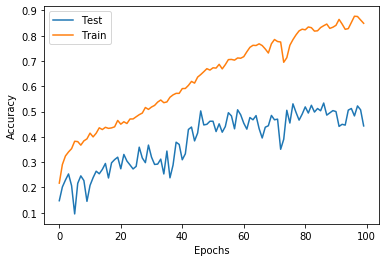

In [146]:
plt.plot(history.history['val_accuracy'], label='Test')
plt.plot(history.history['accuracy'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

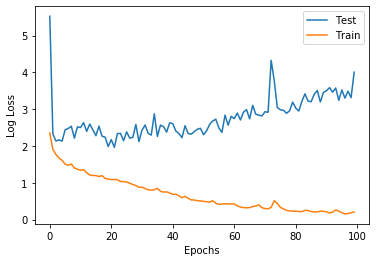

In [147]:
plt.plot(history.history['val_loss'], label='Test')
plt.plot(history.history['loss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [318]:
activation = 'relu'
dropout_rate = 0.5
CNN_model = Sequential()
CNN_model.add(Reshape((6, 100, 1), input_shape=(6,100)))

CNN_model.add(Conv2D(8, kernel_size=(2, 5), activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Conv2D(16, kernel_size=(2, 5), activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Conv2D(32, kernel_size=(3, 5), activation=activation))
#CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(dropout_rate))

CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Dense(32, activation=activation))
CNN_model.add(Dropout(dropout_rate))

CNN_model.add(Dense(num_classes, activation='softmax'))
print(CNN_model.summary())

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_73 (Reshape)         (None, 6, 100, 1)         0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 5, 96, 8)          88        
_________________________________________________________________
dropout_99 (Dropout)         (None, 5, 96, 8)          0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 4, 92, 16)         1296      
_________________________________________________________________
dropout_100 (Dropout)        (None, 4, 92, 16)         0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 2, 88, 32)         7712      
_________________________________________________________________
dropout_101 (Dropout)        (None, 2, 88, 32)       

In [319]:
CNN_model.compile(loss=LogLoss,
                  optimizer='adam',
                  metrics=['accuracy'])

In [320]:
epochs = 500
batch_size = 100
CNN_history = CNN_model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            shuffle=True,
                            validation_data=(X_test, y_test))

Train on 6278 samples, validate on 1570 samples
Epoch 1/500
6278/6278 [==============================] - 11s 2ms/step - loss: 2.6088 - accuracy: 0.1021 - val_loss: 2.5787 - val_accuracy: 0.1261
Epoch 2/500
6278/6278 [==============================] - 9s 1ms/step - loss: 2.5280 - accuracy: 0.1316 - val_loss: 2.5698 - val_accuracy: 0.1433
Epoch 3/500
6278/6278 [==============================] - 10s 2ms/step - loss: 2.4670 - accuracy: 0.1328 - val_loss: 2.6353 - val_accuracy: 0.0624
Epoch 4/500
6278/6278 [==============================] - 12s 2ms/step - loss: 2.4438 - accuracy: 0.1403 - val_loss: 2.3749 - val_accuracy: 0.2312
Epoch 5/500
6278/6278 [==============================] - 9s 1ms/step - loss: 2.3383 - accuracy: 0.2018 - val_loss: 2.3655 - val_accuracy: 0.2293
Epoch 6/500
6278/6278 [==============================] - 9s 1ms/step - loss: 2.2906 - accuracy: 0.2174 - val_loss: 2.2339 - val_accuracy: 0.3025
Epoch 7/500
6278/6278 [==============================] - 9s 1ms/step - loss: 2.

Epoch 57/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4504 - accuracy: 0.3176 - val_loss: 1.5610 - val_accuracy: 0.3013
Epoch 58/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4526 - accuracy: 0.3189 - val_loss: 1.6004 - val_accuracy: 0.3057
Epoch 59/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4274 - accuracy: 0.3270 - val_loss: 1.6542 - val_accuracy: 0.3197
Epoch 60/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4419 - accuracy: 0.3218 - val_loss: 1.6046 - val_accuracy: 0.3490
Epoch 61/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4501 - accuracy: 0.3278 - val_loss: 1.6060 - val_accuracy: 0.2975
Epoch 62/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4288 - accuracy: 0.3186 - val_loss: 1.5343 - val_accuracy: 0.3223
Epoch 63/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4126 - accuracy: 0.3273 - val_loss: 1.5417 -

6278/6278 [==============================] - 8s 1ms/step - loss: 1.2516 - accuracy: 0.3550 - val_loss: 1.6307 - val_accuracy: 0.3732
Epoch 114/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2163 - accuracy: 0.3742 - val_loss: 1.5848 - val_accuracy: 0.3796
Epoch 115/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2628 - accuracy: 0.3687 - val_loss: 1.6094 - val_accuracy: 0.3172
Epoch 116/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.3221 - accuracy: 0.3457 - val_loss: 1.6003 - val_accuracy: 0.3338
Epoch 117/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2353 - accuracy: 0.3597 - val_loss: 1.5728 - val_accuracy: 0.3745
Epoch 118/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2092 - accuracy: 0.3773 - val_loss: 1.6747 - val_accuracy: 0.3459
Epoch 119/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2184 - accuracy: 0.3659 - val_loss: 1.6139 - val_ac

Epoch 169/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1351 - accuracy: 0.3820 - val_loss: 1.6174 - val_accuracy: 0.3650
Epoch 170/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1631 - accuracy: 0.3815 - val_loss: 1.6743 - val_accuracy: 0.3694
Epoch 171/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.4102 - accuracy: 0.3574 - val_loss: 1.6108 - val_accuracy: 0.3484
Epoch 172/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1572 - accuracy: 0.3775 - val_loss: 1.6073 - val_accuracy: 0.3656
Epoch 173/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1595 - accuracy: 0.3917 - val_loss: 1.6886 - val_accuracy: 0.3605
Epoch 174/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1392 - accuracy: 0.3874 - val_loss: 1.7041 - val_accuracy: 0.3650
Epoch 175/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1372 - accuracy: 0.3804 - val_loss: 1

Epoch 225/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0636 - accuracy: 0.4081 - val_loss: 1.6897 - val_accuracy: 0.3924
Epoch 226/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0795 - accuracy: 0.4071 - val_loss: 1.6706 - val_accuracy: 0.3930
Epoch 227/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0712 - accuracy: 0.4116 - val_loss: 1.6372 - val_accuracy: 0.4057
Epoch 228/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0559 - accuracy: 0.4089 - val_loss: 1.6270 - val_accuracy: 0.4000
Epoch 229/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0582 - accuracy: 0.4063 - val_loss: 1.6064 - val_accuracy: 0.3994
Epoch 230/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0589 - accuracy: 0.4138 - val_loss: 1.6675 - val_accuracy: 0.3815
Epoch 231/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0594 - accuracy: 0.4180 - val_loss: 1

Epoch 281/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0368 - accuracy: 0.4156 - val_loss: 1.6557 - val_accuracy: 0.3943
Epoch 282/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9643 - accuracy: 0.4307 - val_loss: 1.7640 - val_accuracy: 0.3994
Epoch 283/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0666 - accuracy: 0.4253 - val_loss: 1.7372 - val_accuracy: 0.3841
Epoch 284/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0654 - accuracy: 0.4178 - val_loss: 1.7109 - val_accuracy: 0.3987
Epoch 285/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0438 - accuracy: 0.4341 - val_loss: 1.6876 - val_accuracy: 0.4076
Epoch 286/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0017 - accuracy: 0.4277 - val_loss: 1.7255 - val_accuracy: 0.4140
Epoch 287/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9923 - accuracy: 0.4301 - val_loss: 1

Epoch 337/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9598 - accuracy: 0.4430 - val_loss: 1.8371 - val_accuracy: 0.4121
Epoch 338/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9676 - accuracy: 0.4527 - val_loss: 1.8336 - val_accuracy: 0.3879
Epoch 339/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9902 - accuracy: 0.4321 - val_loss: 1.7542 - val_accuracy: 0.3994
Epoch 340/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0654 - accuracy: 0.4430 - val_loss: 1.7894 - val_accuracy: 0.3924
Epoch 341/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9795 - accuracy: 0.4433 - val_loss: 1.7466 - val_accuracy: 0.4000
Epoch 342/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9852 - accuracy: 0.4285 - val_loss: 1.6829 - val_accuracy: 0.3968
Epoch 343/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9490 - accuracy: 0.4376 - val_loss: 1

Epoch 393/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.2795 - accuracy: 0.3993 - val_loss: 2.0664 - val_accuracy: 0.3032
Epoch 394/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0982 - accuracy: 0.4076 - val_loss: 1.8086 - val_accuracy: 0.3611
Epoch 395/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.1240 - accuracy: 0.4102 - val_loss: 1.7218 - val_accuracy: 0.3860
Epoch 396/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9714 - accuracy: 0.4336 - val_loss: 1.7746 - val_accuracy: 0.4038
Epoch 397/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9513 - accuracy: 0.4412 - val_loss: 1.8316 - val_accuracy: 0.3892
Epoch 398/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0255 - accuracy: 0.4382 - val_loss: 1.8937 - val_accuracy: 0.3713
Epoch 399/500
6278/6278 [==============================] - 8s 1ms/step - loss: 1.0161 - accuracy: 0.4318 - val_loss: 1

Epoch 449/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9433 - accuracy: 0.4654 - val_loss: 1.7648 - val_accuracy: 0.4159
Epoch 450/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.8955 - accuracy: 0.4785 - val_loss: 1.7488 - val_accuracy: 0.4389
Epoch 451/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.8931 - accuracy: 0.4713 - val_loss: 1.7175 - val_accuracy: 0.4369
Epoch 452/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9343 - accuracy: 0.4680 - val_loss: 1.7948 - val_accuracy: 0.4006
Epoch 453/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.9606 - accuracy: 0.4638 - val_loss: 1.7148 - val_accuracy: 0.4401
Epoch 454/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.8962 - accuracy: 0.4659 - val_loss: 1.7680 - val_accuracy: 0.4312
Epoch 455/500
6278/6278 [==============================] - 8s 1ms/step - loss: 0.8695 - accuracy: 0.4764 - val_loss: 1

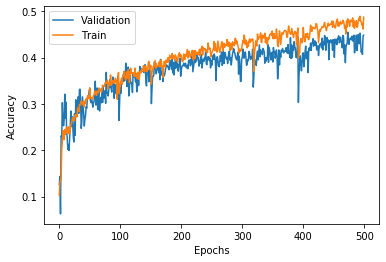

In [324]:
plt.plot(CNN_history.history['val_accuracy'], label='Validation')
plt.plot(CNN_history.history['accuracy'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('CNN_acc_500_epochs.png', dpi=200, bbox_inches='tight')
plt.show()

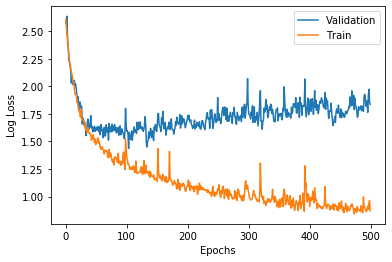

In [325]:
plt.plot(CNN_history.history['val_loss'], label='Validation')
plt.plot(CNN_history.history['loss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.savefig('CNN_loss_500_epochs.png', dpi=200, bbox_inches='tight')
plt.show()

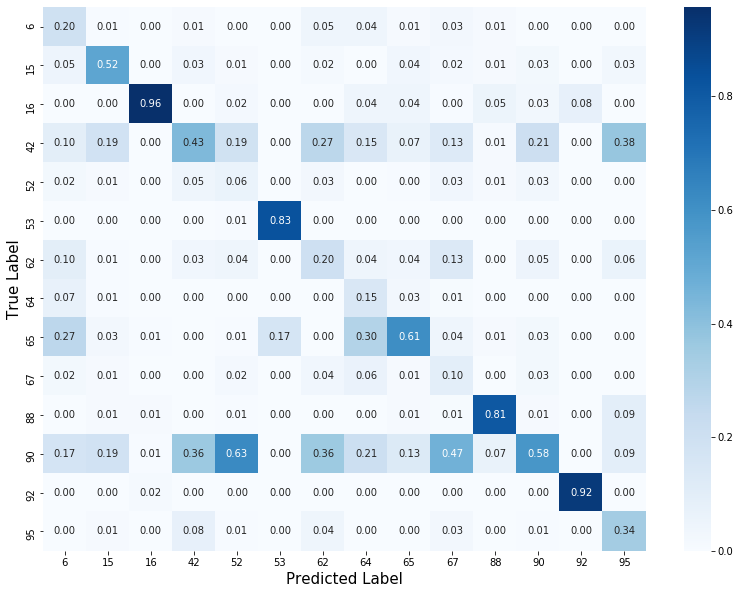

In [326]:
test_pred = CNN_model.predict(X_test)
CNN_cf = confusion_matrix(y_test.argmax(axis=1), test_pred.argmax(axis=1))
CNN_cf_norm = CNN_cf / CNN_cf.sum(axis=0)

plt.figure(figsize = (13.5,10))
sn.heatmap(CNN_cf_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.savefig('CNN_confusion_matrix_500_epochs.png', dpi=200, bbox_inches='tight')
plt.show()